# Figures article
***

In this notebook I create the figures in the paper that show the LISFLOOD, CaMa-Flood and STARTIF reservoir routines.

In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 14})

from reservoirs_lshm import Config, read_attributes, read_timeseries
from reservoirs_lshm.models import get_model
from reservoirs_lshm.calibration import get_calibrator, read_results
from reservoirs_lshm.utils.metrics import KGEmod

In [2]:
path = Path('/home/casadoj/datasets/reservoirs/ResOpsUS/v2.2/results')
path_paper = Path('../../../docs/paper/draft/figures')
grand_id = 355

## CaMa-Flood

In [3]:
from reservoirs_lshm.models.camaflood import plot_camaflood

In [4]:
config_file = path / 'camaflood' / 'camaflood_2var_5par.yml'

cfg = Config(config_file)

# reservoirs = pd.read_csv(cfg.RESERVOIRS_FILE, header=None).squeeze().tolist()

attributes = read_attributes(cfg.PATH_DATA / 'attributes', [grand_id])

with open(cfg.PERIODS_FILE, 'rb') as file:
    periods = pickle.load(file)

inputs = [var for var in [cfg.INFLOW, cfg.PRECIPITATION, cfg.EVAPORATION, cfg.DEMAND] if var]
outputs = ['storage', 'outflow']
timeseries = read_timeseries(
    path=cfg.PATH_DATA / 'time_series' / 'csv',
    reservoirs=attributes.index,
    periods=periods,
    variables=inputs + outputs
)

ts = timeseries[grand_id]

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
dbname = path / cfg.MODEL / 'calibration' / '5par' / 'bivariate' / f'{grand_id}_samples'

# define input time series
inflow = ts[cfg.INFLOW]
precipitation = ts[cfg.PRECIPITATION] if cfg.PRECIPITATION in ts.columns else None
evaporation = ts[cfg.EVAPORATION] if cfg.EVAPORATION in ts.columns else None
demand = ts[cfg.DEMAND] if cfg.DEMAND in ts.columns else None
    
# storage attributes (m3)
Vtot = max(attributes.loc[grand_id, 'CAP_MCM'].item() * 1e6, ts.storage.max())
# Vtot = ts.storage.max()
Vmin = max(0, min(0.1 * Vtot, ts.storage.min()))
# flow attributes (m3/s)
Qmin = max(0, ts.outflow.min())
# catchment area (m2)
catchment = int(attributes.loc[grand_id, 'CATCH_SKM'].item() * 1e6) if cfg.MODEL == 'camaflood' else None
# reservoir area (m2)
Atot = int(attributes.loc[grand_id, 'AREA_SKM'].item() * 1e6)

# configure calibration kwargs
cal_cfg = {}
if cfg.MODEL == 'camaflood':
    cal_cfg.update({'catchment': catchment})
# elif cfg.MODEL == 'mhm':
#     cal_cfg.update({'demand': demand})
# initialize the calibration setup
calibrator = get_calibrator(
    cfg.MODEL,
    parameters=cfg.PARAMETERS,
    inflow=inflow,
    storage=ts.storage,
    outflow=ts.outflow,
    precipitation=precipitation,
    evaporation=evaporation,
    demand=demand,
    Vmin=Vmin,
    Vtot=Vtot,
    Qmin=Qmin,
    Atot=Atot,
    target=cfg.TARGET,
    obj_func=KGEmod,
    spinup=cfg.SPINUP,
    **cal_cfg
)

# read calibration results
results, parameters = read_results(f'{dbname}.csv')

# convert parameter into reservoir attributes
calibrated_attrs = calibrator.pars2attrs(list(parameters.values()))

# declare the reservoir with optimal parameters
camaflood = get_model(cfg.MODEL, **calibrated_attrs)

## LISFLOOD

In [6]:
from reservoirs_lshm.models.lisflood import plot_lisflood

In [7]:
config_file = path / 'lisflood' / 'lisflood_2var_6par.yml'

cfg = Config(config_file)

In [8]:
dbname = path / cfg.MODEL / 'calibration' / '6par' / 'bivariate' / f'{grand_id}_samples'

# define input time series
inflow = ts[cfg.INFLOW]
precipitation = ts[cfg.PRECIPITATION] if cfg.PRECIPITATION in ts.columns else None
evaporation = ts[cfg.EVAPORATION] if cfg.EVAPORATION in ts.columns else None
demand = ts[cfg.DEMAND] if cfg.DEMAND in ts.columns else None
    
# storage attributes (m3)
Vtot = max(attributes.loc[grand_id, 'CAP_MCM'].item() * 1e6, ts.storage.max())
# Vtot = ts.storage.max()
Vmin = max(0, min(0.1 * Vtot, ts.storage.min()))
# flow attributes (m3/s)
Qmin = max(0, ts.outflow.min())
# catchment area (m2)
catchment = int(attributes.loc[grand_id, 'CATCH_SKM'].item() * 1e6) if cfg.MODEL == 'camaflood' else None
# reservoir area (m2)
Atot = int(attributes.loc[grand_id, 'AREA_SKM'].item() * 1e6)

# configure calibration kwargs
cal_cfg = {}
if cfg.MODEL == 'camaflood':
    cal_cfg.update({'catchment': catchment})
# elif cfg.MODEL == 'mhm':
#     cal_cfg.update({'demand': demand})
# initialize the calibration setup
calibrator = get_calibrator(
    cfg.MODEL,
    parameters=cfg.PARAMETERS,
    inflow=inflow,
    storage=ts.storage,
    outflow=ts.outflow,
    precipitation=precipitation,
    evaporation=evaporation,
    demand=demand,
    Vmin=Vmin,
    Vtot=Vtot,
    Qmin=Qmin,
    Atot=Atot,
    target=cfg.TARGET,
    obj_func=KGEmod,
    spinup=cfg.SPINUP,
    **cal_cfg
)

# read calibration results
results, parameters = read_results(f'{dbname}.csv')

# convert parameter into reservoir attributes
calibrated_attrs = calibrator.pars2attrs(list(parameters.values()))

# declare the reservoir with optimal parameters
lisflood = get_model(cfg.MODEL, **calibrated_attrs)

## Paper: LISFLOOD vs CaMa-Flood

Figure saved in: ../../../docs/paper/draft/figures/lisflood_camaflood.pdf


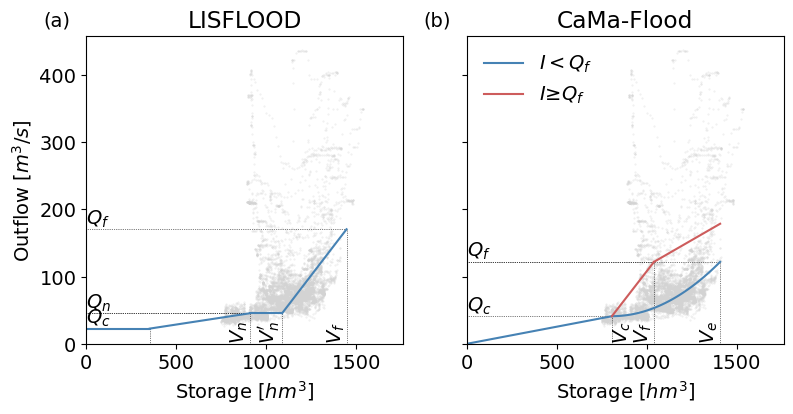

In [9]:
lw = 1.5
c = 'steelblue'

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9, 4), sharex=True, sharey=True)

# LISFLOOD
plot_lisflood(lisflood, ts, ax=ax[0], lw=lw, title='LISFLOOD')
ax[0].text(-0.05, 1.02, '(a)', ha='right', va='bottom', transform=ax[0].transAxes)

# CAMAFLOOD
plot_camaflood(camaflood, ts, ax=ax[1], lw=lw, title='CaMa-Flood', ylabel=None)
ax[1].text(-0.05, 1.02, '(b)', ha='right', va='bottom', transform=ax[1].transAxes)

file_out = path_paper / 'lisflood_camaflood.pdf'
plt.savefig(file_out, dpi=300, bbox_inches='tight')
print(f'Figure saved in: {file_out}')
plt.show()

## STARFIT

In [10]:
from reservoirs_lshm.models.starfit.storage import fit_storage, create_storage_harmonic
from reservoirs_lshm.models.starfit.release import fit_release, create_release_harmonic, create_release_linear
from reservoirs_lshm.models.starfit.functions import plot_nor, plot_release

In [11]:
path = Path('/home/casadoj/datasets/reservoirs/ResOpsUS/v2.1/results')

# read configuration file
config_file = path / 'starfit' / 'starfit.yml'
cfg = Config(config_file)

overwrite = False

PATH_STORAGE = cfg.PATH_DEF.parent / 'NOR'
PATH_RELEASE = cfg.PATH_DEF.parent / 'release'

# convert units
ts['s'] = ts.storage * 1e-6 # MCM
ts[['i', 'r']] = ts[['inflow', 'outflow']] * 1e-6 * 86400 # MCM/day

### Normal operating range

In [12]:
# fit storage model
try:
    for years, n_points in zip([8, 6, 4], [3, 2, 2]):
        model_storage = fit_storage(
            grand_id,
            storage_daily=ts.s,
            attributes=attributes.loc[grand_id],
            min_days=years * 365,
            n_points=n_points,
        )
        if not model_storage['weekly storage'].empty:
            break
    if model_storage['weekly storage'].empty:
        print(f'ERROR: Could not fit storage model for {grand_id}')
except Exception as e:
    print(f'ERROR: Failed to fit storage model for {grand_id}:\n{e}')

# define normal operating range (NOR)
try:
    NORup = create_storage_harmonic(
        model_storage['NOR upper bound'], 
        name='flood'
        ).set_index('epiweek')
    NORdown = create_storage_harmonic(
        model_storage['NOR lower bound'], 
        name='conservation'
        ).set_index('epiweek')
    NOR = pd.concat((NORup, NORdown), axis=1)
except Exception as e:
    print(f'ERROR: Failed to create the normal operating rules (NOR) for {grand_id}\n{e}')

# weekly time series of standardised storage combined with NOR
weekly_storage = model_storage['weekly storage']

### Release model

In [13]:
# fit release model
try:
    for years in [5, 4]:
        model_release = fit_release(
            grand_id,
            daily_ops=ts[['s', 'i', 'r']],
            attributes=attributes.loc[grand_id],
            NOR_path=PATH_STORAGE,
            cutoff_year=None,
            min_weeks=52 * years
        )
        if pd.notna(model_release['mean inflow (MCM/wk)']):
            break
    if not model_release or all(np.isnan(model_release['harmonic parameters'])):
        print(f'ERROR: Could not fit release model for {grand_id}')
except Exception as e:
    print(f'ERROR: Failed to fit release model for {grand_id}\n{e}')

# extract info from the fitted release: average inflow, harmonic release (standardised) and release contraints
try:
    avg_inflow = model_release['mean inflow (MCM/wk)']
    release_harmonic = create_release_harmonic(
        model_release['harmonic parameters']
        ).set_index('epiweek').squeeze()
    release_linear = create_release_linear(model_release['residual parameters'])
    Qmin, Qmax = model_release['constraints']
    weekly_release = model_release['weekly release'].set_index('epiweek')
except Exception as e:
    print(f'ERROR: Failed to create the release rules for {grand_id}')


### Plot paper

Figure saved in: ../../../docs/paper/draft/figures/starfit.pdf


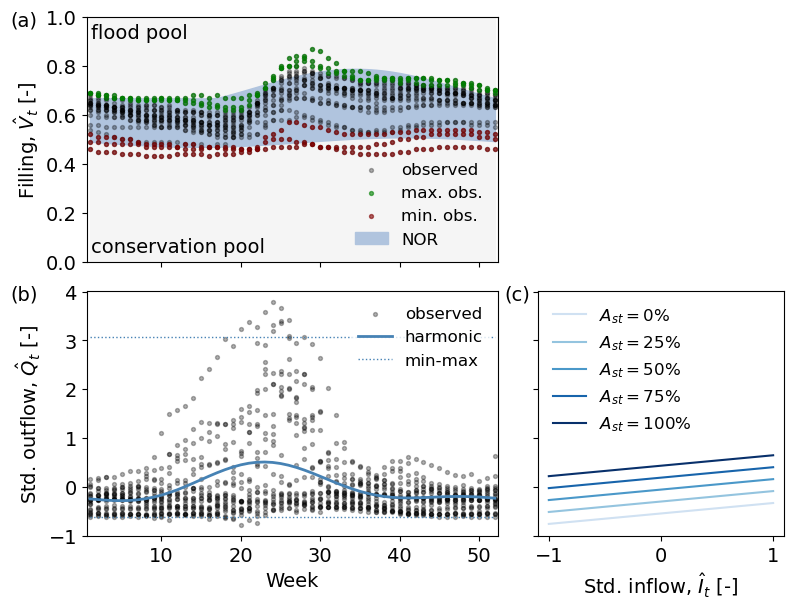

In [14]:
plt.rcParams.update({'legend.fontsize': 12})

fig = plt.figure(
    figsize=(9, 6.75),
    # layout="constrained"
)
gs = GridSpec(
    nrows=2, 
    ncols=2, 
    width_ratios=[7.5, 4.5], 
    wspace=.12,
    hspace=.12,
    # figure=fig
    )

ax_nor = fig.add_subplot(gs[0,0])
ax_Qharm = fig.add_subplot(gs[1,0], sharex=ax_nor)
ax_Qlin =fig.add_subplot(gs[1,1], sharey=ax_Qharm)

plot_nor(weekly_storage, NOR, n_points=n_points, ax=ax_nor)
loc = [-.12, 1.025]
ax_nor.text(*loc, '(a)', ha='right', va='top', transform=ax_nor.transAxes)

plot_release(
        weekly_release.r, 
        avg_inflow, 
        release_harmonic, 
        release_linear, 
        Qmin, 
        Qmax, 
        axes=[ax_Qharm, ax_Qlin]
    )
ax_Qharm.text(*loc, '(b)', ha='right', va='top', transform=ax_Qharm.transAxes)
ax_Qlin.text(-.03, loc[1], '(c)', ha='right', va='top', transform=ax_Qlin.transAxes)

file_out = path_paper / 'starfit.pdf'
plt.savefig(file_out, dpi=300, bbox_inches='tight')
print(f'Figure saved in: {file_out}')
plt.show()